# Low-Rank Transformer Attention Masks Visualization

This notebook visualizes the custom attention masks used in the Low-Rank Transformer model.


In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set matplotlib parameters for larger fonts
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 22
})


## Generate Attention Masks

Parameters:
- V = 5 (number of tables)
- C = 3 (columns per table)
- Sequence length = V*(C+1) + 3 = 5*4 + 3 = 23


In [6]:
def create_attention_masks(V=5, C=3):
    """
    Create attention masks for Low-Rank Transformer.
    
    First 2 layers: Block diagonal (each C+1 group attends to itself) + last 3 tokens
    Remaining layers: Last token of each group + last 3 tokens attend to each other
    """
    seq_len = V * (C + 1) + 3
    
    # Mask for first 2 layers: block diagonal + last 3 tokens
    mask_first_layers = torch.zeros(seq_len, seq_len)
    
    # Each C+1 group attends to itself
    for i in range(V):
        start = i * (C + 1)
        end = start + (C + 1)
        mask_first_layers[start:end, start:end] = 1
    
    # Last 3 tokens attend to themselves only
    mask_first_layers[-3, -3] = 1
    mask_first_layers[-2, -2] = 1
    mask_first_layers[-1, -1] = 1
    
    # Mask for remaining layers: last token of each group + last 3 tokens
    mask_remaining_layers = torch.zeros(seq_len, seq_len)
    
    # Collect indices of last tokens in each C+1 group
    last_token_indices = [(i + 1) * (C + 1) - 1 for i in range(V)]
    last_token_indices.extend([seq_len - 3, seq_len - 2, seq_len - 1])
    
    # These tokens can all attend to each other
    for i in last_token_indices:
        for j in last_token_indices:
            mask_remaining_layers[i, j] = 1
    
    return mask_first_layers, mask_remaining_layers, seq_len

# Generate masks
V, C = 5, 3
mask_first, mask_remaining, seq_len = create_attention_masks(V, C)

print(f"Generated attention masks for V={V}, C={C}")
print(f"Sequence length: {seq_len}")
print(f"First layers mask shape: {mask_first.shape}")
print(f"Remaining layers mask shape: {mask_remaining.shape}")


Generated attention masks for V=5, C=3
Sequence length: 23
First layers mask shape: torch.Size([23, 23])
Remaining layers mask shape: torch.Size([23, 23])


## Visualize Attention Masks


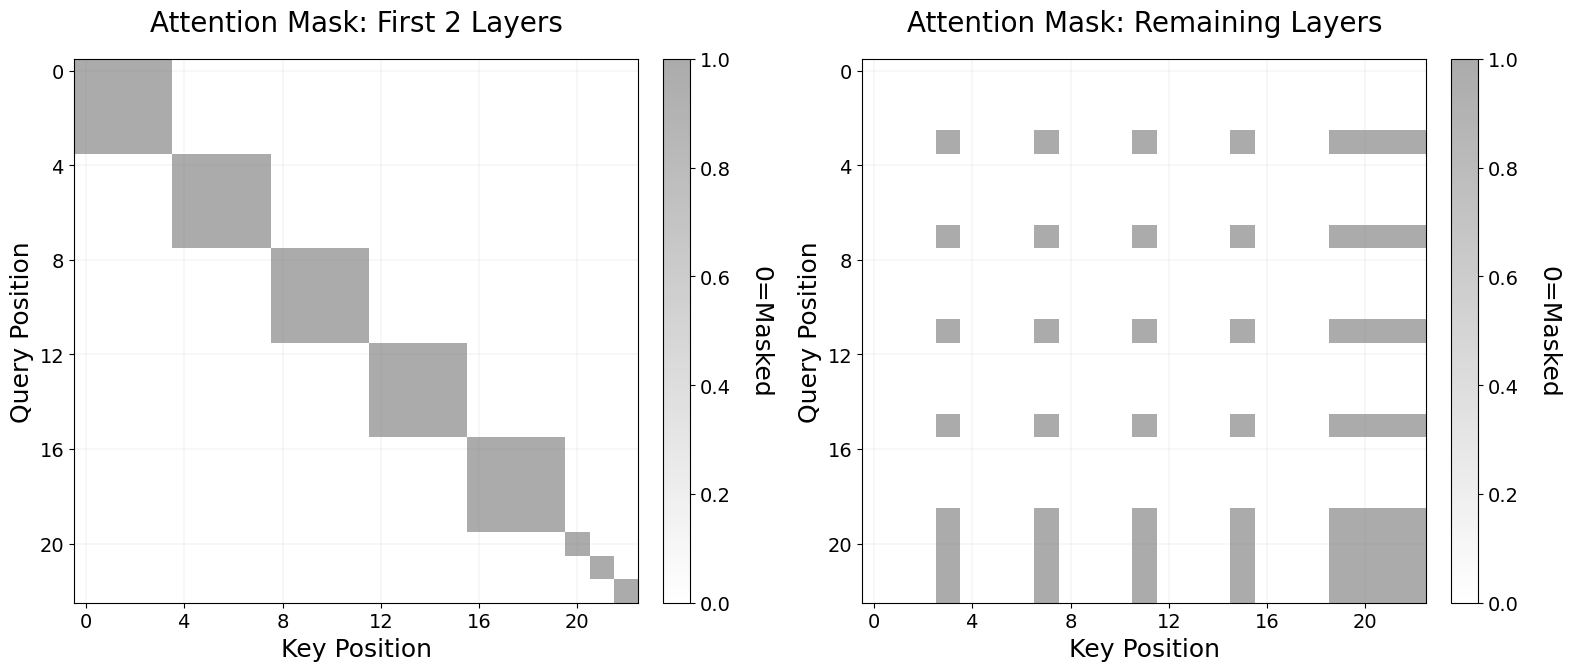

\n✓ Visualization saved as 'attention_masks_visualization.png'


In [13]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Define custom colormap: white (0) to gray (1)
from matplotlib.colors import LinearSegmentedColormap
colors = ['#FFFFFF', '#ABABAB']  # White to Dark Gray
n_bins = 100
cmap = LinearSegmentedColormap.from_list('gray_white', colors, N=n_bins)

# Plot first 2 layers mask
im1 = axes[0].imshow(mask_first.numpy(), cmap=cmap, aspect='auto', vmin=0, vmax=1)
axes[0].set_title('Attention Mask: First 2 Layers', 
                  fontsize=20, pad=20)
axes[0].set_xlabel('Key Position', fontsize=18)
axes[0].set_ylabel('Query Position', fontsize=18)

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('0=Masked', fontsize=18, rotation=270, labelpad=30)
cbar1.ax.tick_params(labelsize=14)

# Plot remaining layers mask
im2 = axes[1].imshow(mask_remaining.numpy(), cmap=cmap, aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Attention Mask: Remaining Layers', 
                  fontsize=20, pad=20)
axes[1].set_xlabel('Key Position', fontsize=18)
axes[1].set_ylabel('Query Position', fontsize=18)

# Add colorbar
cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('0=Masked', fontsize=18, rotation=270, labelpad=30)
cbar2.ax.tick_params(labelsize=14)

# Add grid for better readability
for ax in axes:
    ax.set_xticks(np.arange(0, seq_len, 4))
    ax.set_yticks(np.arange(0, seq_len, 4))
    ax.grid(True, which='both', color='gray', linewidth=0.3, alpha=0.3)

plt.tight_layout()
plt.savefig('attention_masks_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\\n✓ Visualization saved as 'attention_masks_visualization.png'")


In [4]:
# Calculate statistics
total_positions = seq_len * seq_len
first_layer_connections = mask_first.sum().item()
remaining_layer_connections = mask_remaining.sum().item()

print(f"Total possible attention connections: {total_positions}")
print(f"\\nFirst 2 layers:")
print(f"  Active connections: {int(first_layer_connections)}")
print(f"  Sparsity: {100 * first_layer_connections / total_positions:.2f}%")
print(f"\\nRemaining layers:")
print(f"  Active connections: {int(remaining_layer_connections)}")
print(f"  Sparsity: {100 * remaining_layer_connections / total_positions:.2f}%")

# Show which positions can attend in remaining layers
last_token_indices = [(i + 1) * (C + 1) - 1 for i in range(V)]
last_token_indices.extend([seq_len - 3, seq_len - 2, seq_len - 1])
print(f"\\nPositions that attend in remaining layers: {last_token_indices}")
print(f"Number of attending positions: {len(last_token_indices)}")


Total possible attention connections: 529
\nFirst 2 layers:
  Active connections: 83
  Sparsity: 15.69%
\nRemaining layers:
  Active connections: 64
  Sparsity: 12.10%
\nPositions that attend in remaining layers: [3, 7, 11, 15, 19, 20, 21, 22]
Number of attending positions: 8
